In [133]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax


import context
from samplers.sgld import sgld_time_budget
from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed



# Successive halving tuning tests

In [134]:

from examples.logistic_regression.logistic_regression_model import gen_data_and_log_post


dim = 10
Ndata = 100000
key = random.PRNGKey(0) 
theta_true, X, y_data, val_and_grad_log_post = gen_data_and_log_post(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)


@jit
def fb_grads_LR_train(theta):
    return val_and_grad_log_post(theta, X_train, y_train)[1]

batch_fb_grads_LR_train = jit(vmap(fb_grads_LR_train, in_axes=(0,)))

generating data, with N=100000 and dim=10
(80000, 10) (20000, 10)


## define samplers

### 1. LR

In [135]:
def get_KSD_LR(key, time_budget, dt, b_s_r):
    thin_step = 5
    batch_size = int(X_train.shape[0]*b_s_r)
    x_0 = theta_true
    samples, stoch_grads = sgld_time_budget(key, val_and_grad_log_post, X_train, y_train, 
                                           time_budget, dt, batch_size, x_0)
    print(f"Number of samples: {len(samples)}")
    fullbatch_grads = batch_fb_grads_LR_train(samples)

    ksd_fb = imq_KSD(samples, fullbatch_grads)
    ksd_fb_thin = imq_KSD(samples[::thin_step], fullbatch_grads[::thin_step])
    ksd_stoch = imq_KSD(samples, stoch_grads)
    ksd_stoch_thin = imq_KSD(samples[::thin_step], stoch_grads[::thin_step])

    return ksd_fb, ksd_fb_thin, ksd_stoch, ksd_stoch_thin

In [136]:
key = random.PRNGKey(0)
b_s_r = 0.1
dt = 10**(-4)

time_budget = 3

get_KSD_LR(key, time_budget, dt, b_s_r)

Number of samples: 4883


(DeviceArray(10.697095, dtype=float32),
 DeviceArray(11.3973055, dtype=float32),
 DeviceArray(13.24429, dtype=float32),
 DeviceArray(29.570112, dtype=float32))

### 2. PMF

In [137]:
from examples.PMF.pmf_model import grad_log_post
from examples.PMF.util import R_train, R_test, flatten_PMF_params, load_PMF_MAP
from examples.PMF.sgld_PMF_functions import sgld_PMF_time_budget


In [138]:
def get_KSD_PMF(key, time_budget, dt, b_s_r):
    thin_step = 5
    batch_size = int(R_train.shape[0]*b_s_r)
    MAP_params = load_PMF_MAP()
    samples, stoch_grads = sgld_PMF_time_budget(key, time_budget, grad_log_post, 
                                            dt, batch_size, MAP_params, R_train, save_rate=1)
    print(f"Number of samples: {len(samples)}")
    fullbatch_grads = [grad_log_post(sam, R_train) for sam in samples]
    
    flat_samples = flatten_PMF_params(samples)
    flat_stoch_grads = flatten_PMF_params(stoch_grads)
    flat_fullbatch_grads = flatten_PMF_params(fullbatch_grads)

    ksd_fb = imq_KSD(flat_samples, flat_fullbatch_grads)
    ksd_fb_thin = imq_KSD(flat_samples[::thin_step], flat_fullbatch_grads[::thin_step])
    ksd_stoch = imq_KSD(flat_samples, flat_stoch_grads)
    ksd_stoch_thin = imq_KSD(flat_samples[::thin_step], flat_stoch_grads[::thin_step])

    return ksd_fb, ksd_fb_thin, ksd_stoch, ksd_stoch_thin

In [ ]:
key = random.PRNGKey(0)
b_s_r = 0.01
dt = 10**(-4)

time_budget = 1

get_KSD_PMF(key, time_budget, dt, b_s_r)


### 3. NN

In [ ]:
from examples.bayesian_NN.NN_data import X_train as X_train_NN
from examples.bayesian_NN.NN_data import y_train as y_train_NN
from examples.bayesian_NN.NN_model import grad_log_post
from examples.bayesian_NN.util import flatten_NN_params, load_NN_MAP
from examples.bayesian_NN.sampler import sgld_NN_time_budget


In [ ]:
def get_KSD_NN(key, time_budget, dt, b_s_r):
    thin_step = 5
    batch_size = int(X_train_NN.shape[0]*b_s_r)
    MAP_params = load_NN_MAP()
    samples, stoch_grads = sgld_NN_time_budget(key, time_budget, grad_log_post, dt, 
                                    batch_size, MAP_params, X_train_NN, y_train_NN, save_rate=1)
    print(f"Number of samples: {len(samples)}")
    fullbatch_grads = [grad_log_post(sam, X_train_NN, y_train_NN) for sam in samples]
    
    flat_samples = flatten_NN_params(samples)
    flat_stoch_grads = flatten_NN_params(stoch_grads)
    flat_fullbatch_grads = flatten_NN_params(fullbatch_grads)

    ksd_fb = imq_KSD(flat_samples, flat_fullbatch_grads)
    ksd_fb_thin = imq_KSD(flat_samples[::thin_step], flat_fullbatch_grads[::thin_step])
    ksd_stoch = imq_KSD(flat_samples, flat_stoch_grads)
    ksd_stoch_thin = imq_KSD(flat_samples[::thin_step], flat_stoch_grads[::thin_step])

    return ksd_fb, ksd_fb_thin, ksd_stoch, ksd_stoch_thin

In [75]:
key = random.PRNGKey(0)
b_s_r = 0.01
dt = 10**(-4)

time_budget = 1

get_KSD_NN(key, time_budget, dt, b_s_r)


Number of samples: 344


KeyboardInterrupt: 

## Run grid search



In [140]:
# ranges for step size and batch size
log_dt_range = np.arange(-6.5,-2.5, 0.5)
dt_range = 10**(log_dt_range)

log_b_s_r_range = np.arange(0,3,0.5)
b_s_r_range = 10**(-log_b_s_r_range)

# initialise the dictionaries
list_ksd_names = ['ksd_list_fb', 'ksd_list_fb_thin', 'ksd_list_stoch', 'ksd_list_stoch_thin']

dict_LR_dt_range = {k:[] for k in list_ksd_names}
dict_PMF_dt_range = {k:[] for k in list_ksd_names}
dict_NN_dt_range = {k:[] for k in list_ksd_names}


dict_LR_b_s_r_range = {k:[] for k in list_ksd_names}
dict_PMF_b_s_r_range = {k:[] for k in list_ksd_names}
dict_NN_b_s_r_range = {k:[] for k in list_ksd_names}

## 1. Logistic regression

In [141]:
# grid search over step size
b_s_r = 0.01

for dt in dt_range:
    print(f"dt: {dt:.6f}")
    ksd_estimates = get_KSD_LR(key, time_budget, dt, b_s_r)
    for names, ksd_est in zip(list_ksd_names, ksd_estimates):
        dict_LR_dt_range[names].append(ksd_est)
        
        
# grid search over batch size

dt = 10**(-4.5)

for b_s_r in b_s_r_range:
    print(f"b_s_r: {b_s_r:.4f}")
    ksd_estimates = get_KSD_LR(key, time_budget, dt, b_s_r)
    for names, ksd_est in zip(list_ksd_names, ksd_estimates):
        dict_LR_b_s_r_range[names].append(ksd_est)
        
        

dt: 0.000000
Number of samples: 2131
dt: 0.000001
Number of samples: 2101
dt: 0.000003
Number of samples: 2094
dt: 0.000010
Number of samples: 2121
dt: 0.000032
Number of samples: 2125
dt: 0.000100
Number of samples: 2102
dt: 0.000316
Number of samples: 2118
dt: 0.001000
Number of samples: 1997
b_s_r: 1.0000
Number of samples: 453
b_s_r: 0.3162
Number of samples: 1022
b_s_r: 0.1000
Number of samples: 1740
b_s_r: 0.0316
Number of samples: 2204
b_s_r: 0.0100
Number of samples: 2224
b_s_r: 0.0032
Number of samples: 2163


In [142]:
# # save LR runs
# for names, ksdlist in dict_LR_dt_range.items():
#     np.savetxt(f"outputs/SH_tests/LR/dt_range/{names}.txt", ksdlist)
    
# for names, ksdlist in dict_LR_b_s_r_range.items():
#     np.savetxt(f"outputs/SH_tests/LR/b_s_r_range/{names}.txt", ksdlist)
    


## 2. PMF

In [143]:
# grid search over step size
b_s_r = 0.01

for dt in dt_range:
    print(f"dt: {dt:.6f}")
    ksd_estimates = get_KSD_PMF(key, time_budget, dt, b_s_r)
    for names, ksd_est in zip(list_ksd_names, ksd_estimates):
        dict_PMF_dt_range[names].append(ksd_est)
        
        

dt: 0.000000
Number of samples: 566
dt: 0.000001
Number of samples: 646
dt: 0.000003
Number of samples: 635
dt: 0.000010
Number of samples: 622
dt: 0.000032
Number of samples: 631
dt: 0.000100
Number of samples: 570
dt: 0.000316
Number of samples: 595
dt: 0.001000
Number of samples: 597


In [144]:
# # save PMF runs
# for names, ksdlist in dict_PMF_dt_range.items():
#     np.savetxt(f"outputs/SH_tests/PMF/dt_range/{names}.txt", ksdlist)
    

In [145]:
# grid search over batch size
dt = 10**(-4.5)

for b_s_r in b_s_r_range:
    print(f"b_s_r: {b_s_r:.4f}")
    ksd_estimates = get_KSD_PMF(key, time_budget, dt, b_s_r)
    for names, ksd_est in zip(list_ksd_names, ksd_estimates):
        dict_PMF_b_s_r_range[names].append(ksd_est)
        
        

b_s_r: 1.0000
Number of samples: 83
b_s_r: 0.3162
Number of samples: 252
b_s_r: 0.1000
Number of samples: 402
b_s_r: 0.0316
Number of samples: 545
b_s_r: 0.0100
Number of samples: 573
b_s_r: 0.0032
Number of samples: 603


In [146]:
# for names, ksdlist in dict_PMF_b_s_r_range.items():
#     np.savetxt(f"outputs/SH_tests/PMF/b_s_r_range/{names}.txt", ksdlist)
    


## 3. NN

In [79]:
# grid search over step size
b_s_r = 0.01

for dt in dt_range:
    print(f"dt: {dt:.6f}")
    ksd_estimates = get_KSD_NN(key, time_budget, dt, b_s_r)
    for names, ksd_est in zip(list_ksd_names, ksd_estimates):
        dict_NN_dt_range[names].append(ksd_est)
        
        

dt: 0.000000
Number of samples: 335
dt: 0.000001
Number of samples: 347
dt: 0.000003
Number of samples: 347
dt: 0.000010
Number of samples: 345
dt: 0.000032
Number of samples: 348
dt: 0.000100
Number of samples: 411
dt: 0.000316
Number of samples: 424
dt: 0.001000
Number of samples: 419


In [110]:
# save NN runs
# for names, ksdlist in dict_NN_dt_range.items():
#     np.savetxt(f"outputs/SH_tests/NN/dt_range/{names}.txt", ksdlist)
    

In [81]:
# grid search over batch size
dt = 10**(-4.5)


for b_s_r in b_s_r_range:
    print(f"b_s_r: {b_s_r:.4f}")
    ksd_estimates = get_KSD_NN(key, time_budget, dt, b_s_r)
    for names, ksd_est in zip(list_ksd_names, ksd_estimates):
        dict_NN_b_s_r_range[names].append(ksd_est)
        
        

b_s_r: 1.0000
Number of samples: 8
b_s_r: 0.3162
Number of samples: 23
b_s_r: 0.1000
Number of samples: 67
b_s_r: 0.0316
Number of samples: 199
b_s_r: 0.0100
Number of samples: 414
b_s_r: 0.0032
Number of samples: 643


In [131]:
# for names, ksdlist in dict_NN_b_s_r_range.items():
#     np.savetxt(f"outputs/SH_tests/NN/b_s_r_range/{names}.txt", ksdlist)
    


# create plot

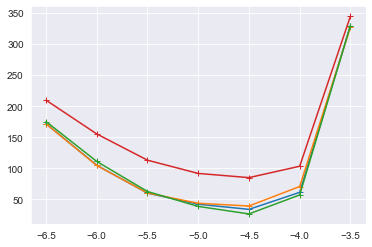

In [22]:
cut_list = 1

for k,v in dict_LR_dt_range.items():
    plt.plot(log_dt_range[:-cut_list], v[:-cut_list], marker="+")


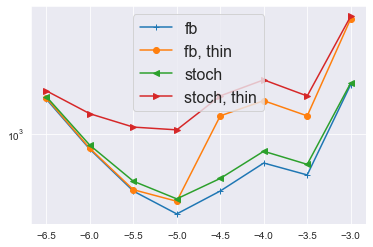

In [149]:
plt.plot(log_dt_range, dict_NN_dt_range['ksd_list_fb'], marker="+", label="fb")
plt.plot(log_dt_range, dict_NN_dt_range['ksd_list_fb_thin'], marker="o", label="fb, thin")
plt.plot(log_dt_range, dict_NN_dt_range['ksd_list_stoch'], marker="<", label="stoch")
plt.plot(log_dt_range, dict_NN_dt_range['ksd_list_stoch_thin'], marker=">", label="stoch, thin")
plt.yscale("log")

plt.legend(fontsize=16)

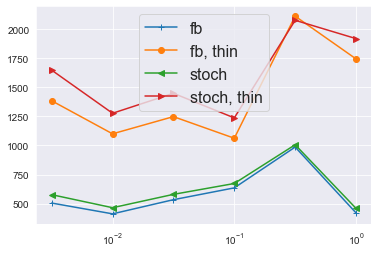

In [150]:
plt.plot(b_s_r_range, dict_NN_b_s_r_range['ksd_list_fb'], marker="+", label="fb")
plt.plot(b_s_r_range, dict_NN_b_s_r_range['ksd_list_fb_thin'], marker="o", label="fb, thin")
plt.plot(b_s_r_range, dict_NN_b_s_r_range['ksd_list_stoch'], marker="<", label="stoch")
plt.plot(b_s_r_range, dict_NN_b_s_r_range['ksd_list_stoch_thin'], marker=">", label="stoch, thin")
plt.xscale("log")

plt.legend(fontsize=16)

### 3 figures

In [148]:
# Load data for figures
list_ksd_names = ['ksd_list_fb', 'ksd_list_fb_thin', 'ksd_list_stoch', 'ksd_list_stoch_thin']

# ========
# Logistic regression
dict_LR_dt_range = {}
for names in list_ksd_names:
    dict_LR_dt_range[names] = np.genfromtxt(f"outputs/SH_tests/LR/dt_range/{names}.txt")
    
dict_LR_b_s_r_range = {}
for names in list_ksd_names:
    dict_LR_b_s_r_range[names] = np.genfromtxt(f"outputs/SH_tests/LR/b_s_r_range/{names}.txt")
    

# ========
# PMF
dict_PMF_dt_range = {}
for names in list_ksd_names:
    dict_PMF_dt_range[names] = np.genfromtxt(f"outputs/SH_tests/PMF/dt_range/{names}.txt")
    
dict_PMF_b_s_r_range = {}
for names in list_ksd_names:
    dict_PMF_b_s_r_range[names] = np.genfromtxt(f"outputs/SH_tests/PMF/b_s_r_range/{names}.txt")

# ========   
# NN
dict_NN_dt_range = {}
for names in list_ksd_names:
    dict_NN_dt_range[names] = np.genfromtxt(f"outputs/SH_tests/NN/dt_range/{names}.txt")
    
dict_NN_b_s_r_range = {}
for names in list_ksd_names:
    dict_NN_b_s_r_range[names] = np.genfromtxt(f"outputs/SH_tests/NN/b_s_r_range/{names}.txt")
    
    

#### grid search of batch size

In [170]:
dict_LR_b_s_r_range.keys()

dict_keys(['ksd_list_fb', 'ksd_list_fb_thin', 'ksd_list_stoch', 'ksd_list_stoch_thin'])

In [171]:
dict_LR_dt_range.keys()

dict_keys(['ksd_list_fb', 'ksd_list_fb_thin', 'ksd_list_stoch', 'ksd_list_stoch_thin'])

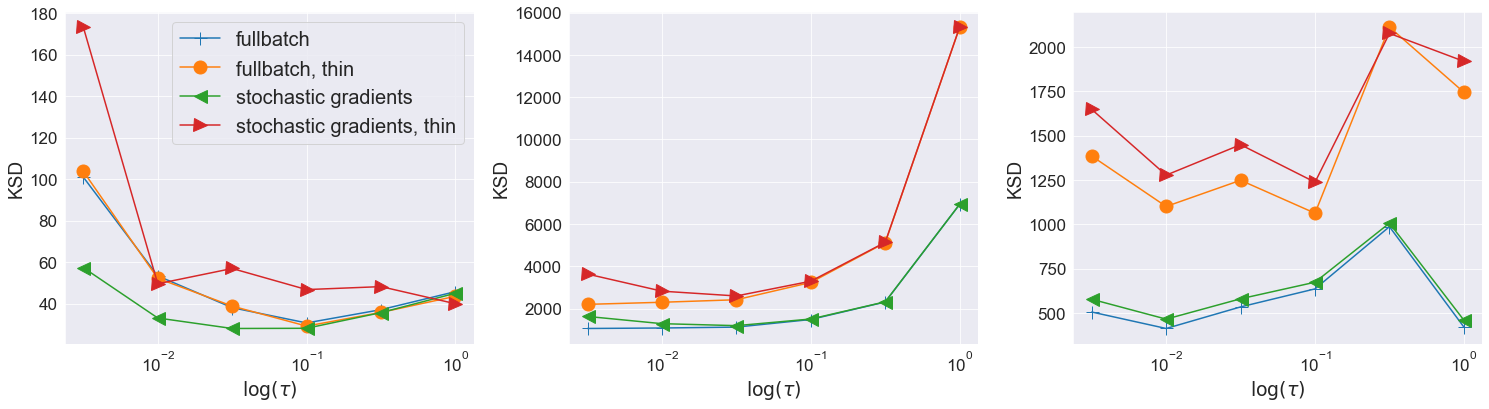

In [184]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=False)


markerlist = ["+", "o", "<", ">"]
list_legend_title = ['fullbatch', 'fullbatch, thin', 'stochastic gradients', 'stochastic gradients, thin']

# ========
# Logistic regression
cut_list = 1
for ksdlist, mker, leg in zip(dict_LR_b_s_r_range.values(), markerlist, list_legend_title):
    ax[0].plot(b_s_r_range, ksdlist, marker=mker, label=leg, markersize=13)
    
ax[0].set_xlabel(r"$\log(\tau)$", size=19)
ax[0].set_xscale("log")

# ========
# PMF
for ksdlist, mker in zip(dict_PMF_b_s_r_range.values(), markerlist):
    ax[1].plot(b_s_r_range, ksdlist, marker=mker, markersize=13)

ax[1].set_xlabel(r"$\log(\tau)$", size=19)
ax[1].set_xscale("log")


# ========
# NN
for ksdlist, mker in zip(dict_NN_b_s_r_range.values(), markerlist):
    ax[2].plot(b_s_r_range, ksdlist, marker=mker, markersize=13)

ax[2].set_xlabel(r"$\log(\tau)$", size=19)
ax[2].set_xscale("log")

ax[0].set_ylabel("KSD", size=19)
ax[1].set_ylabel("KSD", size=19)
ax[2].set_ylabel("KSD", size=19)
ax[0].legend(fontsize=20)
plt.tight_layout()

# plt.savefig("images/KSD_tests_batch_size.png")

#### grid search of step size

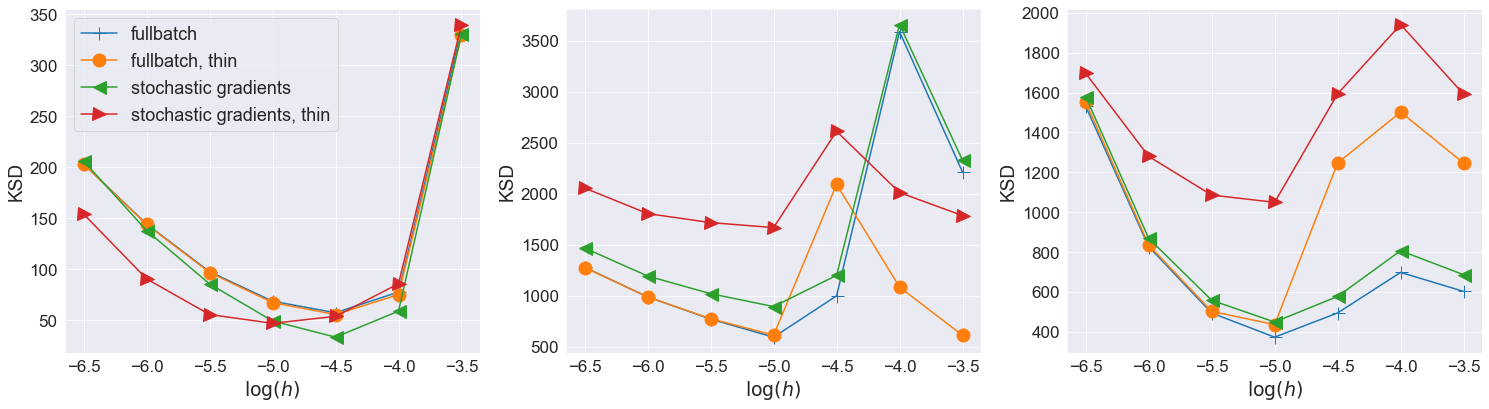

In [185]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=False)

markerlist = ["+", "o", "<", ">"]

# ========
# Logistic regression
cut_list = 1
for ksdlist, mker, leg in zip(dict_LR_dt_range.values(), markerlist, list_legend_title):
    ax[0].plot(log_dt_range[:-cut_list], ksdlist[:-cut_list], marker=mker, label=leg, markersize=13)
    
ax[0].set_xlabel(r"$\log(h)$", size=19)



# ========
# PMF
cut_list = 1
for ksdlist, mker in zip(dict_PMF_dt_range.values(), markerlist):
    ax[1].plot(log_dt_range[:-cut_list], ksdlist[:-cut_list], marker=mker, markersize=13)

ax[1].set_xlabel(r"$\log(h)$", size=19)



# ========
# NN
cut_list = 1
for ksdlist, mker in zip(dict_NN_dt_range.values(), markerlist):
    ax[2].plot(log_dt_range[:-cut_list], ksdlist[:-cut_list], marker=mker, markersize=13)

ax[2].set_xlabel(r"$\log(h)$", size=19)

ax[0].set_ylabel("KSD", size=19)
ax[1].set_ylabel("KSD", size=19)
ax[2].set_ylabel("KSD", size=19)
ax[0].legend(fontsize=18)
plt.tight_layout()
# plt.savefig("images/KSD_tests_step_size.png")